https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features

## Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid', palette='deep')

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, TargetEncoder

# https://contrib.scikit-learn.org/category_encoders/
# from category_encoders.ordinal import OrdinalEncoder
# from category_encoders.woe import WOEEncoder
# from category_encoders.target_encoder import TargetEncoder
# from category_encoders.sum_coding import SumEncoder
# from category_encoders.m_estimate import MEstimateEncoder
# from category_encoders.leave_one_out import LeaveOneOutEncoder
# from category_encoders.helmert import HelmertEncoder
# from category_encoders.cat_boost import CatBoostEncoder
# from category_encoders.james_stein import JamesSteinEncoder
# from category_encoders.one_hot import OneHotEncoder

## Загрузка данных и предварительный анализ

Загрузим датасет и посмотрим что внутри

In [2]:
df = pd.read_csv("abalone.data", 
                 names=['sex',  # M, F, and I (infant) 
                        'length',  # Longest shell measurement, mm
                        'diameter',  # perpendicular to length, mm
                        'height',  # with meat in shell, mm
                        'whole_weight',  # whole abalone, grams
                        'shucked_weight',  # weight of meat, grams
                        'viscera_weight',  # gut weight (after bleeding), grams
                        'shell_weight',  # after being dried, grams
                        'rings'  # +1.5 gives the age in years
                 ])
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4177 non-null   object 
 1   length          4177 non-null   float64
 2   diameter        4177 non-null   float64
 3   height          4177 non-null   float64
 4   whole_weight    4177 non-null   float64
 5   shucked_weight  4177 non-null   float64
 6   viscera_weight  4177 non-null   float64
 7   shell_weight    4177 non-null   float64
 8   rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [4]:
df.describe()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


Пропусков нет, посмотрим распределение

In [5]:
features = ["length", "diameter", "height", "whole_weight", "shucked_weight", "viscera_weight", "shell_weight"]
target = ["rings"]

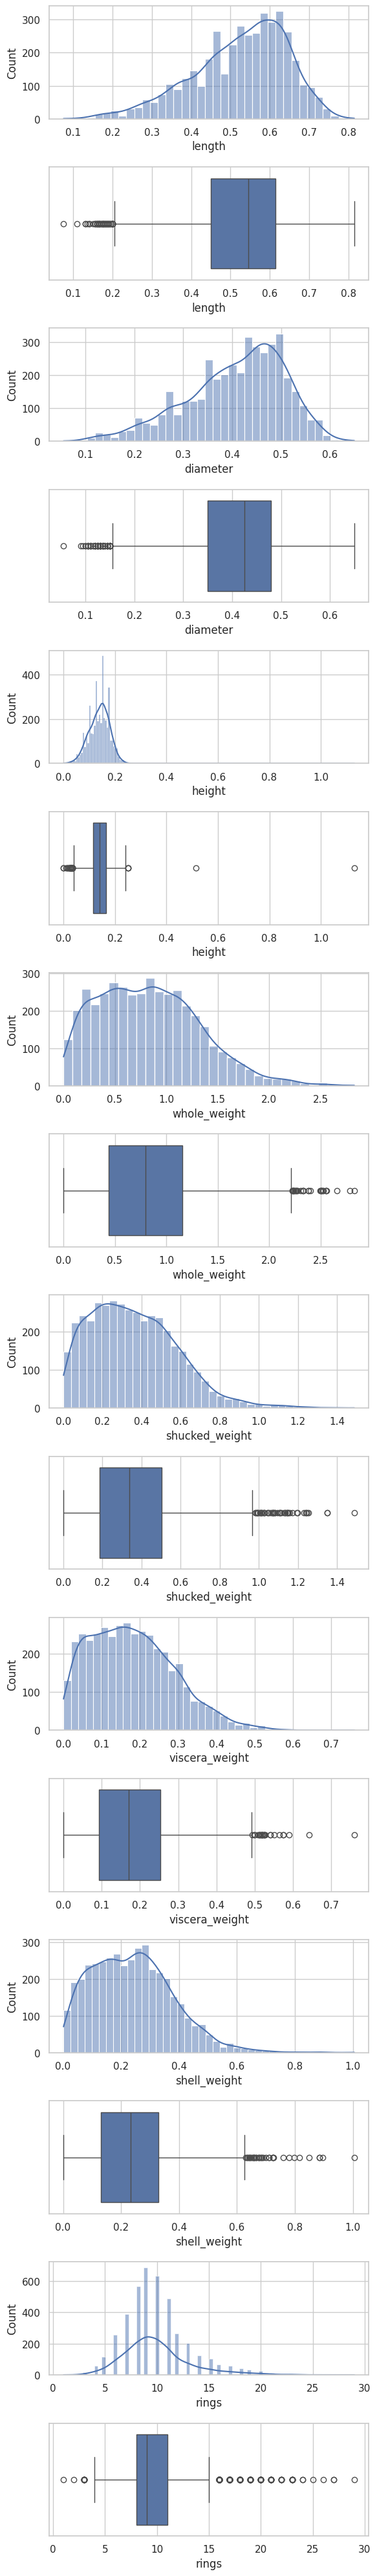

In [6]:
n_rows = len(features + target) * 2
n_cols = 1
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6, 40))

for ax, feature in enumerate(features + target):
    row = ax * 2
    sns.histplot(data=df, x=feature, kde=True, ax=axes[row])
    sns.boxplot(data=df, x=feature, ax=axes[row+1])
    # axs[row][col].set_title(feature)
    
plt.tight_layout()

plt.show()

Все численные показатели не центрированы и имеют выбросы. 
Данный факт следует учесть в дальнейшем при масштабировании фич.

Построим корреляционную матрицу

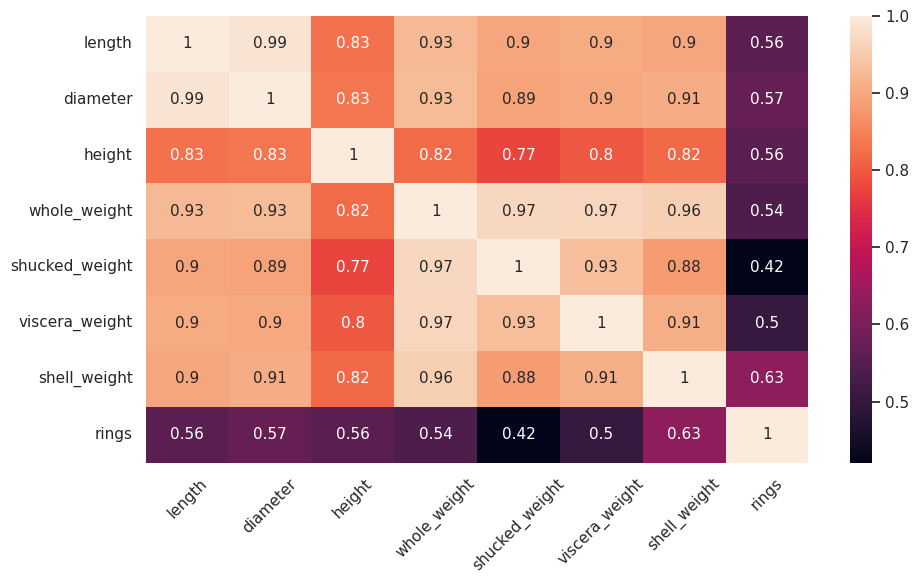

In [7]:
plt.figure(figsize=(10, 6))

corr_matrix = df[features + target].corr()
sns.heatmap(corr_matrix, annot=True, annot_kws={"fontsize":11})

plt.ylabel('')
plt.xlabel('')
plt.title('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Наблюдаем ярко выраженную мультиколлинеарность фич. 
Данный факт следует учесть в дальнейшем при понижении размерности.

Посмотрим на количественную характеристику нашей категориальной фичи "sex"

In [8]:
df["sex"].describe()

count     4177
unique       3
top          M
freq      1528
Name: sex, dtype: object

<Axes: xlabel='sex', ylabel='percent'>

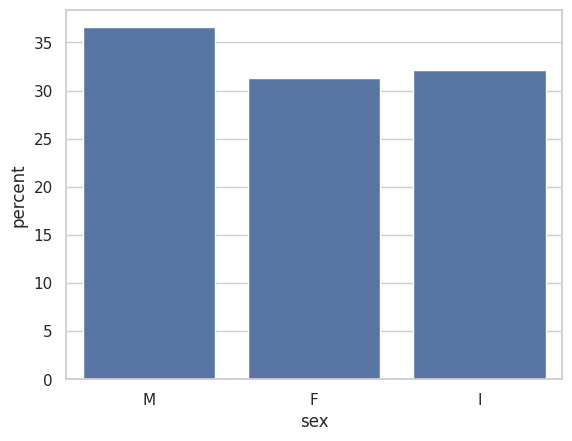

In [9]:
sns.countplot(data=df, x = "sex", stat="percent")

Никакое из значений не является редким, все представлены приблизительно в равной пропорции.
Данный факт следует учитывать при кодировании данного категориального признака.

Кодирование средствами pandas

## pd.get_dummies

Convert categorical variable into dummy/indicator variables.

Each variable is converted in as many 0/1 variables as there are different values. 
Columns in the output are each named after a value; if the input is a DataFrame, 
the name of the original variable is prepended to the value.

Каждая переменная преобразуется в столько переменных 0/1, сколько существует разных значений. 
Каждый столбец в выходных данных назван в честь значения; если входные данные представляют собой DataFrame, 
к значению добавляется имя исходной переменной.

In [10]:
dummies = pd.get_dummies(df, columns=['sex'], drop_first=False, sparse=False)
dummies

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_F,sex_I,sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,False,False,True
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,False,False,True
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,True,False,False
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,False,False,True
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,True,False,False
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,False,False,True
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,False,False,True
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,True,False,False


Для того чтобы в дальнейшем использовать категорию, перекодированную таким образом, 
следует выполнить замену False -> 0, True -> 1

In [11]:
replace_dict = {False:0, True:1}
dummies.replace(replace_dict, inplace=True)
dummies

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_F,sex_I,sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,1,0,0
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,0,0,1
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,0,0,1
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,1,0,0


## LabelEncoder()

Encode target labels with value between 0 and n_classes-1.
This transformer should be used to encode target values, i.e. y, and not the input X.

Кодируйте целевые метки со значением от 0 до n_classes-1.
Этот преобразователь следует использовать для кодирования целевых значений, т.е. y, а не входных значений X.

Несмотря на то, что в документации не рекомендовано применять LabelEncoder для входных данных, 
используем его для понимания как именно он работает. 

In [12]:
le = LabelEncoder()

df['sex_le'] = le.fit_transform(df['sex'])
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_le
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,2
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,2
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,2
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,1


Видим, что значения нашей фичи закодированы с 0 в алфавитном порядке:
F = 0
I = 1
M = 2

## OrdinalEncoder()

Кодируйте категориальные функции как целочисленный массив.

Входные данные этого преобразователя должны представлять собой массив целых чисел или строк, 
обозначающих значения, принимаемые категориальными (дискретными) признаками. 
Характеристики преобразуются в порядковые целые числа. 
В результате получается один столбец целых чисел (от 0 до n_categories – 1) для каждого объекта.

Однако такое целочисленное представление не может использоваться напрямую со всеми 
оценщиками scikit-learn, поскольку они ожидают непрерывного ввода и будут интерпретировать 
категории как упорядоченные, что часто нежелательно.

Иными словами, OrdinalEncoder рекомендован в тех случаях, когда значения категориального признака
могут быть упорядочены (например, оценки в школе A, B, C, D...)



### Штатный OrdinalEncoder из sklearn

In [13]:
oe = OrdinalEncoder()

df['sex_oe'] = oe.fit_transform(df[['sex']])
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_le,sex_oe
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,2,2.0
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,2,2.0
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0,0.0
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,2,2.0
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,1,1.0


Получаем тот же результат, чо и в случае применения LabelEncoder, только тип значений не int, а float

### OrdinalEncoder из библиотеки Category Encoders

In [14]:
from category_encoders.ordinal import OrdinalEncoder

oe = OrdinalEncoder()
df['sex_oe'] = oe.fit_transform(df['sex'])
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_le,sex_oe
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,2,1
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,2,1
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0,2
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,2,1
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,1,3


Обращаем внимание на то, что в данном случае перекодированные значения начинаются не с 0, 
как при использовании штатного энкодера, а с 1.
Значения упорядочены по мере того, как они встречаются в нашей колонке:
M = 1
F = 2
I = 3

In [15]:
df.drop(["sex_le", "sex_oe"], axis=1, inplace=True)

## OneHotEncoder()

Другая возможность преобразовать категориальные функции в функции, 
которые можно использовать с оценщиками scikit-learn, — это использовать 
кодирование «один из K», также известное как «горячее» или фиктивное кодирование. 
Этот тип кодирования можно получить с помощью OneHotEncoder, 
который преобразует каждый категориальный признак с n_categories возможными 
значениями в n_categories двоичные признаки, причем один из них равен 1, а все остальные — 0.

По умолчанию значения, которые может принимать каждый объект, автоматически 
выводятся из набора данных и могут быть найдены в categories_ атрибуте

Это можно указать явно с помощью параметра categories.

Если существует вероятность того, что в обучающих данных могут отсутствовать 
категориальные функции, зачастую лучше указать их handle_unknown='infrequent_if_exist'
вместо установки categories вручную, как указано выше. 
Если handle_unknown='infrequent_if_exist' указан параметр и во время преобразования 
встречаются неизвестные категории, ошибка не возникнет, но результирующие столбцы 
с горячим кодированием для этой функции будут состоять из нулей или будут считаться 
редко встречающейся категорией, если она включена. 
(handle_unknown='infrequent_if_exist' поддерживается только для горячего кодирования)

### Штатный OneHotEncoder из sklearn 

In [16]:
# Со штатным OneHotEncoder в sklearn танцы, поэтому добавлю комментариев.

# Создаем объект-перекодировщик
ohe = OneHotEncoder(sparse_output=False)

# Перекодируем данные. 
# OneHotEncoder принимает на вход таблицу. Для того чтобы он смог перекодировать один столбец, 
# этот столбец сначала нужно загнать в numpy.array а затем сделать reshape(-1, 1). 
# В таком случае столбец превратится в двумерную таблицу с n строками и 1 столбцом (ну не бред?)  
# ohe_sex = ohe.fit_transform(df["sex"].to_numpy().reshape(-1,1))

# Другой способ получить тот же результат - заключить интересующий нас столбец в 
# двойные квадратные скобки. Получим как бы список списков
ohe_sex = ohe.fit_transform(df[["sex"]])

# Перекодировщик возвращает нам numpy.ndarray, поэтому теперь танцуем обратно - 
# переводим наш numpy.ndarray массив в pandas.dataframe
ohe_sex_df = pd.DataFrame(ohe_sex, columns=ohe.get_feature_names_out())

# Присоединяем датафрейм с нашей перекодированной фичей к основному датафрейму, выводим результат
pd.concat([df, ohe_sex_df], axis=1)

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_F,sex_I,sex_M
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,0.0,0.0,1.0
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,0.0,0.0,1.0
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,1.0,0.0,0.0
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,0.0,0.0,1.0
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,1.0,0.0,0.0
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,0.0,0.0,1.0
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,0.0,0.0,1.0
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,1.0,0.0,0.0


### OneHotEncoder из библиотеки Category Encoders 

_Category Encoders_ https://contrib.scikit-learn.org/category_encoders/index.html
A set of scikit-learn-style transformers for encoding categorical variables
into numeric with different techniques. While ordinal, one-hot, and hashing 
encoders have similar equivalents in the existing scikit-learn version, 
the transformers in this library all share a few useful properties:
* First-class support for pandas dataframes as an input (and optionally as output)
* Can explicitly configure which columns in the data are encoded by name or index, or infer non-numeric columns regardless of input type
* Can drop any columns with very low variance based on training set optionally
* Portability: train a transformer on data, pickle it, reuse it later and get the same thing out.
* Full compatibility with sklearn pipelines, input an array-like dataset like any other transformer (*)


Набор преобразователей в стиле scikit-learn для кодирования категориальных переменных в 
числовые с использованием различных методов. Хотя порядковые кодеры, 
кодеры one-hot и хэш-кодеры имеют схожие эквиваленты в существующей версии scikit-learn, 
все преобразователи в этой библиотеке имеют несколько общих полезных свойств:
* Первоклассная поддержка фреймов данных pandas в качестве входных данных (и, возможно, выходных данных).
* Можно явно указать, какие столбцы в данных кодируются по имени или индексу, или вывести нечисловые столбцы независимо от типа входных данных.
* При необходимости можно удалить любые столбцы с очень низкой дисперсией на основе обучающего набора.
* Портативность: обучайте преобразователь на данных, маринуйте их, повторно используйте позже и получайте то же самое.
* Полная совместимость с конвейерами sklearn, ввод массива данных, как и любой другой преобразователь (*)

In [17]:
# Все то же самое, только без танцев с переводом в numpy.ndarray и обратно, 
# можно сделать с OneHotEncoder из библиотеки category_encoders

from category_encoders.one_hot import OneHotEncoder
ohe = OneHotEncoder()
ohe_sex_df = ohe.fit_transform(df["sex"])
pd.concat([df, ohe_sex_df], axis=1)

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_1,sex_2,sex_3
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,1,0,0
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,1,0,0
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,0,1,0
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,1,0,0
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,0,1,0
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,1,0,0
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,1,0,0
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,0,1,0


## TargetEncoder()

The TargetEncoder uses the target mean conditioned on the categorical 
feature for encoding unordered categories, i.e. nominal categories. 
This encoding scheme is useful with categorical features with high cardinality, 
where one-hot encoding would inflate the feature space making it more 
expensive for a downstream model to process. A classical example of high 
cardinality categories are location based such as zip code or region.

Для кодирования неупорядоченных категорий используется TargetEncoder 
целевое среднее, обусловленное категориальным признаком, то есть номинальные 
категории. Эта схема кодирования полезна для категориальных функций с высокой 
мощностью, когда горячее кодирование приведет к увеличению пространства функций, 
что сделает его обработку более дорогой для последующей модели. 
Классическим примером категорий с высокой кардинальностью являются местоположение, 
например почтовый индекс или регион.

### Штатный TargetEncoder из sklearn

In [18]:
te = TargetEncoder(target_type="continuous")
# Помним, что штатные методы не ждут одномерный массив, поэтому 
# или .to_numpy.reshape(-1, 1) или двойные квадратные скобки 
# при передаче столбца X, если он один
te_sex = te.fit_transform(df[['sex']], df['rings'])   
te_sex_df = pd.DataFrame(te_sex, columns=["sex_te"])
pd.concat([df, te_sex_df], axis=1)

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_te
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,10.680344
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,10.680344
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,11.200992
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,10.706416
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,7.907984
...,...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,11.143961
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,10.706416
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,10.773296
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,11.200992


### TargetEncoder из библиотеки Category Encoders

In [19]:
# Тот же результат, но без дополнительной перекодировки в pandas.DataFrame получаем 
# при использовании перекодировщика из библиотеки Category Encoders

from category_encoders.target_encoder import TargetEncoder
te = TargetEncoder()
te_df = te.fit_transform(df['sex'], df['rings'])
pd.concat([df, te_df], axis=1)

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,10.705497
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,10.705497
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,11.129304
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,10.705497
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,7.890462
...,...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,11.129304
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,10.705497
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,10.705497
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,11.129304
